In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_ar1_time_series(n_points=1000, n_dims=1, drift_point=500,
                             phi_initial=0.5, phi_final=0.9,
                             noise_std_low=0.1, noise_std_high=0.5):
    """
    Generate a multivariate AR(1) time-series with drift in AR coefficient and noise.
    """
    data = np.zeros((n_points, n_dims))
    regimes = np.zeros(n_points, dtype=int)

    phi_values = np.concatenate([
        np.full(drift_point, phi_initial),
        np.linspace(phi_initial, phi_final, n_points - drift_point)
    ])

    for t in range(1, n_points):
        noise_std = noise_std_low if t < drift_point else noise_std_high
        noise = np.random.normal(scale=noise_std, size=n_dims)
        data[t, :] = phi_values[t] * data[t-1, :] + noise
        regimes[t] = 0 if t < drift_point else 1

    return data, regimes

def _create_stationary_matrix(dim, seed=None):
    """
    Helper function to create a VAR(1) coefficient matrix
    """
    if dim == 0:
        return np.zeros((0, 0))
        
    rng = np.random.RandomState(seed)
    # Generate a random matrix (entries from standard normal distribution)
    A = rng.randn(dim, dim)
    
    eigenvalues = np.linalg.eigvals(A)
    max_abs_eig = np.max(np.abs(eigenvalues))
    
    if max_abs_eig >= 1.0:
        # Scale the matrix to ensure all eigenvalues have modulus < 1
        if max_abs_eig < 1e-9: # Effectively zero.
             pass
        else:
            A = A / (max_abs_eig * 1.05)
            
    return A

def generate_var_time_series(n_points=1000, dim=5, drift_point=500,
                             real_drift_point=750, extra_noise_dim=2, noise_std=0.1):
    """
    Generate a VAR process with virtual and real concept drifts:
    """
    # Input validation
    if not (0 <= drift_point <= n_points and 0 <= real_drift_point <= n_points):
        raise ValueError(f"drift_point ({drift_point}) and real_drift_point ({real_drift_point}) "
                         f"must be within [0, n_points ({n_points})]")
    

    # 1. Initialize Coefficient Matrices (A1, A2, A3)
    A1 = _create_stationary_matrix(dim, seed=42)
    A2 = _create_stationary_matrix(dim, seed=43)
    A3 = _create_stationary_matrix(dim, seed=44)

    if dim > 0:
        if np.allclose(A1, A2): A2 = _create_stationary_matrix(dim, seed=430) 
        if np.allclose(A2, A3) or np.allclose(A1,A3): A3 = _create_stationary_matrix(dim, seed=440)


    # 2. Initialize Data Array and Regime Indicators
    data_core = np.zeros((n_points, dim))
    regime_indicators = np.zeros(n_points, dtype=int)
    
    rng_noise = np.random.RandomState(seed=123) 

    if n_points == 0:
        total_dims = dim + extra_noise_dim
        return np.zeros((0, total_dims if total_dims > 0 else 0)), np.zeros(0, dtype=int)

    # 3. Generate Time Series Data
    if dim > 0:
        data_core[0, :] = rng_noise.normal(0, noise_std, dim)
    
    # Determine regime for the first point
    if 0 < drift_point:
        regime_indicators[0] = 0
    elif 0 < real_drift_point:
        regime_indicators[0] = 1
    else:
        regime_indicators[0] = 2
        
    for t in range(1, n_points):
        if dim > 0:
            noise = rng_noise.normal(0, noise_std, dim)
        else:
            noise = np.array([])

        current_A = None

        if t < drift_point:
            regime_indicators[t] = 0
            current_A = A1
        elif t < real_drift_point:
            regime_indicators[t] = 1
            
            duration_virtual_drift_regime = real_drift_point - drift_point
            
            k_step_in_regime = t - drift_point 

            if duration_virtual_drift_regime <= 0:
                alpha = 0.0 
            elif duration_virtual_drift_regime == 1:
                alpha = 1.0 
            else:
                alpha = k_step_in_regime / float(duration_virtual_drift_regime - 1)
            
            if dim > 0:
                current_A = (1 - alpha) * A1 + alpha * A2
            else:
                current_A = np.zeros((0,0))

        else:
            regime_indicators[t] = 2
            current_A = A3
        
        if dim > 0:
            data_core[t, :] = current_A @ data_core[t-1, :] + noise

    # 4. Generate Extra Noise Dimensions
    if extra_noise_dim > 0:
        extra_noise_data = rng_noise.normal(0, noise_std, (n_points, extra_noise_dim))
        # 5. Combine Core Data and Extra Noise
        if dim > 0:
            data_full = np.concatenate((data_core, extra_noise_data), axis=1)
        else:
            data_full = extra_noise_data
    else:
        data_full = data_core

    return data_full, regime_indicators


def generate_hybrid_time_series(n_points=1000, n_dims=1,
                                drift_virtual_start=300, drift_real_point=600,
                                phi=0.6, season_amplitude_initial=1.0, season_amplitude_final=2.0,
                                seasonal_period=50):
    """
    Generate hybrid time series with virtual drift in seasonal amplitude and a real drift inversion.
    """
    data = np.zeros((n_points, n_dims))
    regimes = np.zeros(n_points, dtype=int)
    time_index = np.arange(n_points)
    phases = np.random.uniform(0, 2*np.pi, size=n_dims)

    for d in range(n_dims):
        seasonal = np.sin(2 * np.pi * time_index / seasonal_period + phases[d])
        for t in range(1, n_points):
            if t < drift_virtual_start:
                seasonal_coef = season_amplitude_initial
                regimes[t] = 0
            elif t < drift_real_point:
                alpha = (t - drift_virtual_start) / (drift_real_point - drift_virtual_start)
                seasonal_coef = (1 - alpha) * season_amplitude_initial + alpha * season_amplitude_final
                regimes[t] = 1
            else:
                seasonal_coef = -season_amplitude_final
                regimes[t] = 2

            impulsive_noise = np.random.normal(scale=5.0) if np.random.rand() < 0.01 else 0
            gaussian_noise = np.random.normal(scale=0.5)
            noise = gaussian_noise + impulsive_noise

            data[t, d] = phi * data[t-1, d] + seasonal_coef * seasonal[t] + noise

    return data, regimes

In [ ]:
def plot_time_series(data, regimes, title="Time Series with Regimes"):
    n_points, n_dims = data.shape
    fig, axes = plt.subplots(n_dims, 1, figsize=(12, 3 * n_dims), sharex=True)

    if n_dims == 1:
        axes = [axes]  # Make iterable if only one dimension

    # Identify where regime changes occur
    regime_changes = np.where(np.diff(regimes) != 0)[0] + 1
    change_points = [0] + list(regime_changes) + [n_points]

    for i in range(n_dims):
        ax = axes[i]
        ax.plot(data[:, i], label=f"Dimension {i+1}", color='blue')

        # Shade background by regime
        for start, end in zip(change_points[:-1], change_points[1:]):
            regime_id = regimes[start]
            color = f"C{regime_id % 10}"  # Cycle through matplotlib colors
            ax.axvspan(start, end, color=color, alpha=0.1, label=f"Regime {regime_id}" if i == 0 else None)

        ax.set_ylabel("Value")
        ax.set_title(f"{title} - Dimension {i+1}")
        ax.grid(True)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

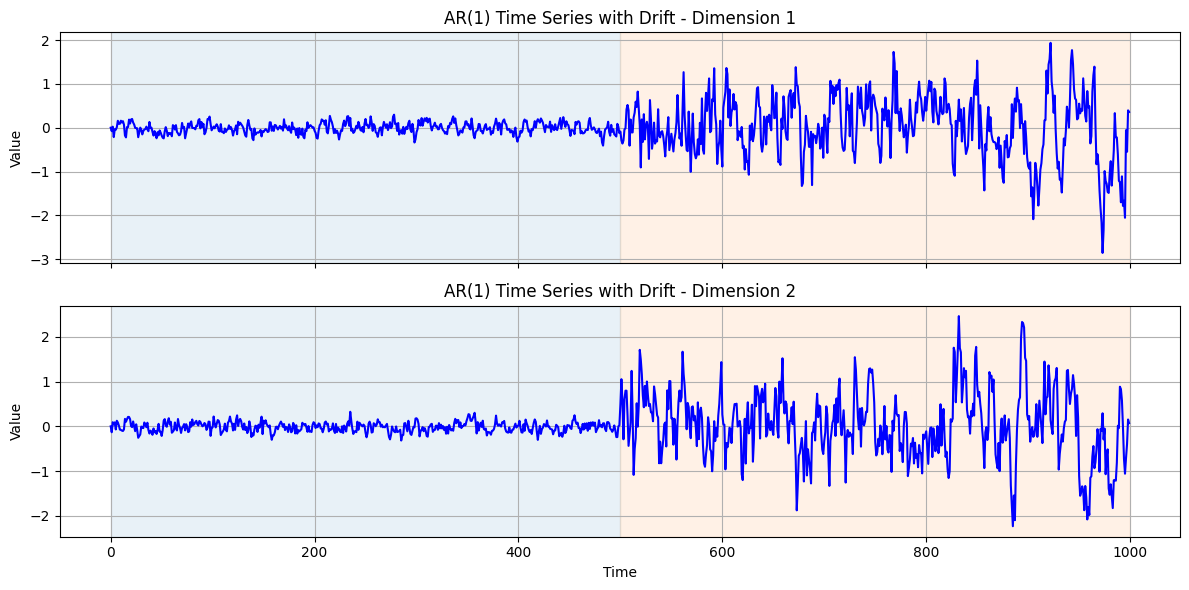

In [76]:
ar1_data, ar1_regimes = generate_ar1_time_series(n_points=1000, n_dims=2)
plot_time_series(ar1_data, ar1_regimes, title="AR(1) Time Series with Drift")

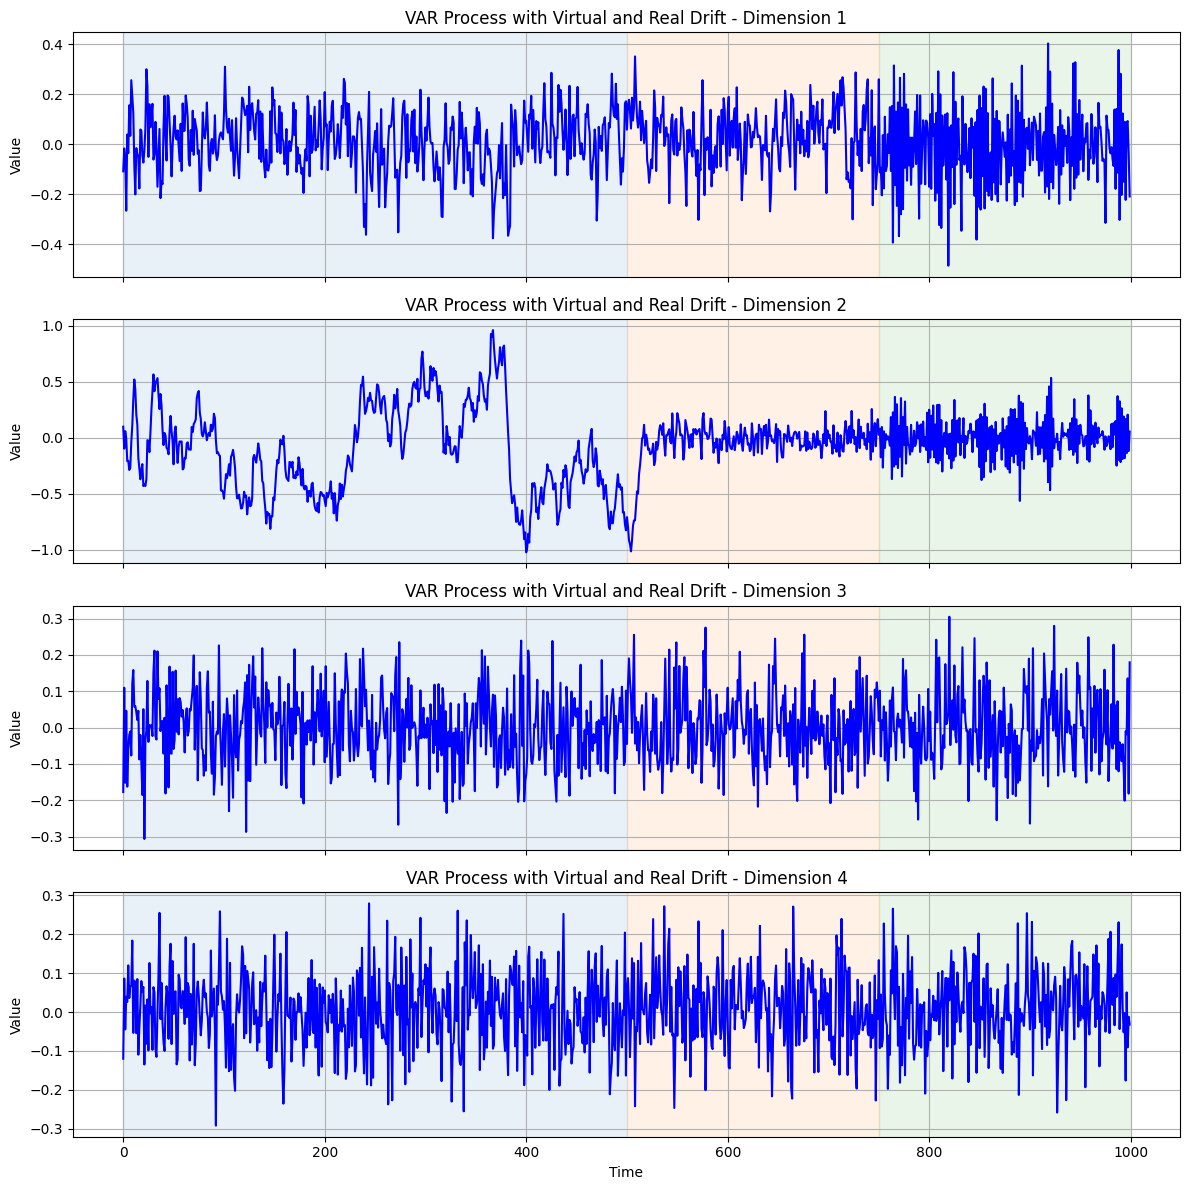

In [77]:
var_data, var_regimes = generate_var_time_series(n_points=1000, dim=2, extra_noise_dim=2)
plot_time_series(var_data, var_regimes, title="VAR Process with Virtual and Real Drift")

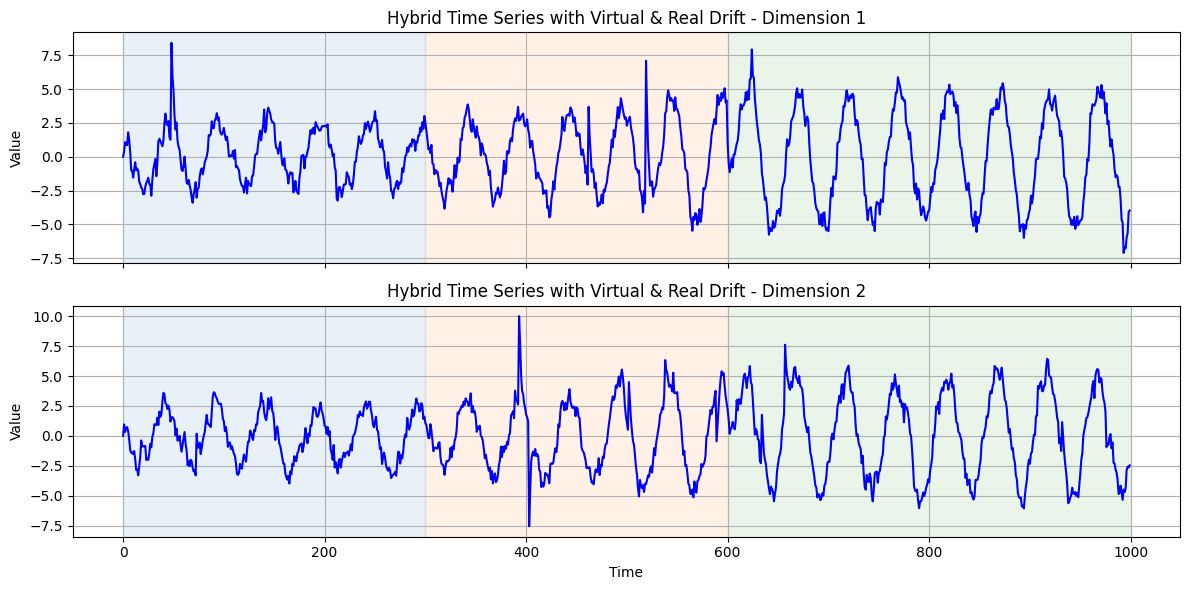

In [78]:
hybrid_data, hybrid_regimes = generate_hybrid_time_series(n_points=1000, n_dims=2)
plot_time_series(hybrid_data, hybrid_regimes, title="Hybrid Time Series with Virtual & Real Drift")

In [23]:
import pandas as pd
import yfinance as yf
import datetime

In [25]:
end_time = datetime.datetime.now()
end_time_str = end_time.strftime("%Y-%m-%d")
end_time_str

'2025-05-09'

In [26]:
start_time = end_time - datetime.timedelta(days=729)
start_time_str = start_time.strftime("%Y-%m-%d")
start_time_str

'2023-05-11'

In [59]:
data = yf.download('BTC-USD', 
                   start=start_time_str, 
                   end=end_time_str, 
                     interval='1h',
                   progress=False)

In [60]:
data.reset_index(inplace=True)
data.columns = ['datetime', 'close', 'high', 'low', 'open', 'volume']
data.head()

,datetime,close,high,low,open,volume
0,2023-05-11 00:00:00+00:00,27543.375000,27621.941406,27466.685547,27621.085938,0
1,2023-05-11 01:00:00+00:00,27580.125000,27596.220703,27513.365234,27537.283203,0
2,2023-05-11 02:00:00+00:00,27520.087891,27591.130859,27515.759766,27576.443359,0
3,2023-05-11 03:00:00+00:00,27451.984375,27519.871094,27426.103516,27519.871094,261320704
4,2023-05-11 04:00:00+00:00,27511.130859,27512.017578,27425.751953,27460.283203,1299378176


In [63]:
data.to_csv('../data/btc_data.csv', index=False)

In [64]:
data = yf.download('ETH-USD', 
                   start=start_time_str, 
                   end=end_time_str, 
                     interval='1h',
                   progress=False)

In [65]:
data.reset_index(inplace=True)
data.columns = ['datetime', 'close', 'high', 'low', 'open', 'volume']
data.head()

,datetime,close,high,low,open,volume
0,2023-05-11 00:00:00+00:00,1833.974365,1842.492065,1829.094727,1842.492065,0
1,2023-05-11 01:00:00+00:00,1836.377563,1838.126831,1831.742554,1833.305176,2299904
2,2023-05-11 02:00:00+00:00,1833.815063,1836.361694,1832.146240,1836.002808,0
3,2023-05-11 03:00:00+00:00,1827.541260,1833.827881,1825.628784,1833.827881,96732160
4,2023-05-11 04:00:00+00:00,1831.225952,1831.277466,1826.510132,1828.521729,33006592


In [66]:
data.to_csv('../data/eth_data.csv', index=False)

In [67]:
def generate_crypto_time_series(data_path, n_points):
    df = pd.read_csv(data_path)
    data = df['close'].values
    data = data[-n_points:]
    return data, None

In [69]:
data = generate_crypto_time_series('../data/btc_data.csv', n_points=1000)

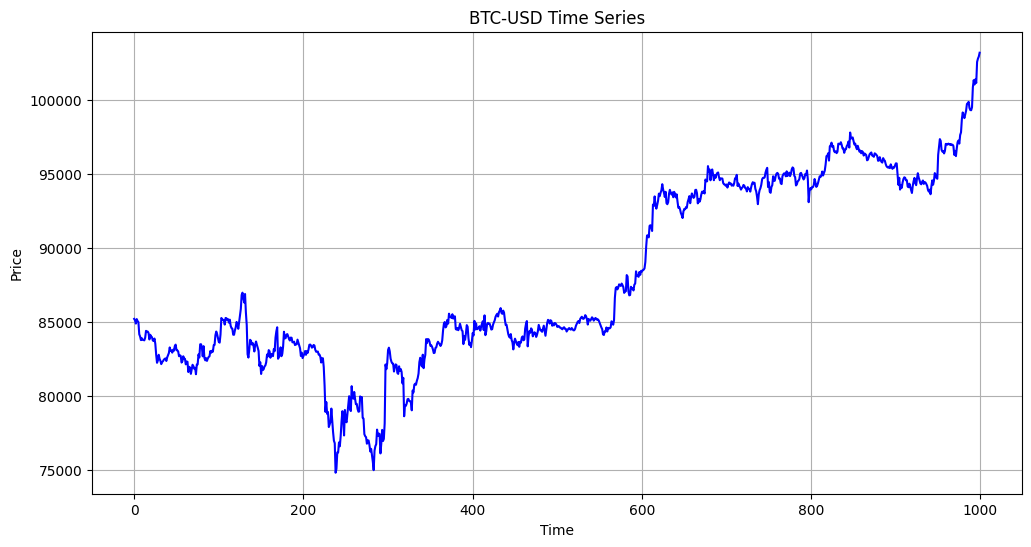

In [71]:
# plot data
plt.figure(figsize=(12, 6))
plt.plot(data[0], label='BTC-USD', color='blue')
plt.title('BTC-USD Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid()
plt.show()

In [72]:
data = generate_crypto_time_series('../data/eth_data.csv', n_points=1000)

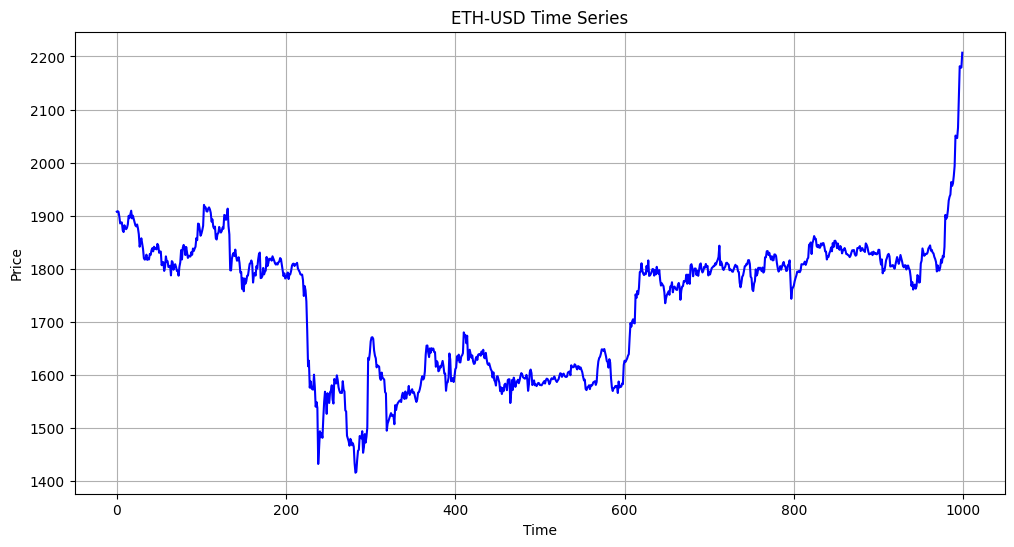

In [73]:
# plot data
plt.figure(figsize=(12, 6))
plt.plot(data[0], label='ETH-USD', color='blue')
plt.title('ETH-USD Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid()
plt.show()